# 手書き文字認識AIを作ってみよう

In [1]:
from utils import mnist

In [2]:
mn = mnist.MnistModel()

In [3]:
# 学習用とテストデータの総数を確認する
mn.show_dataset_num()

学習用データ　　: 60000個
学習用ラベル　　: 60000個
テスト用データ　: 10000個
テスト用ラベル　: 10000個


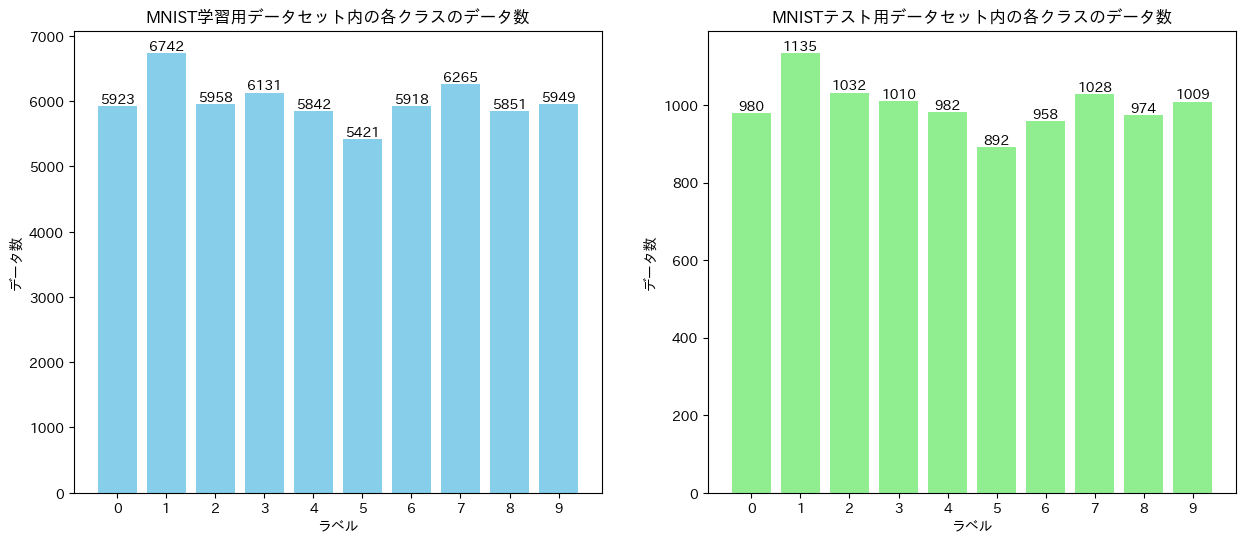

In [4]:
# 学習とテストのデータが各数字ずついくつくらいあるかを確認する
mn.show_dataset_graph()

In [5]:
# チェックするデータの数
num_samples = 10

mn.display_mnist_samples(n=num_samples)

,Image,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,label_9
0,,0,0,0,0,0,1,0,0,0,0
1,,1,0,0,0,0,0,0,0,0,0
2,,0,0,0,0,1,0,0,0,0,0
3,,0,1,0,0,0,0,0,0,0,0
4,,0,0,0,0,0,0,0,0,0,1
5,,0,0,1,0,0,0,0,0,0,0
6,,0,1,0,0,0,0,0,0,0,0
7,,0,0,0,1,0,0,0,0,0,0
8,,0,1,0,0,0,0,0,0,0,0
9,,0,0,0,0,1,0,0,0,0,0


In [6]:
# チェックするデータの数
num_samples = 10

# チェックする手書きの数字
choose_label_class = 7

mn.display_mnist_samples(choose_label_class, n=num_samples)

,Image,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,label_9
0,,0,0,0,0,0,0,0,1,0,0
1,,0,0,0,0,0,0,0,1,0,0
2,,0,0,0,0,0,0,0,1,0,0
3,,0,0,0,0,0,0,0,1,0,0
4,,0,0,0,0,0,0,0,1,0,0
5,,0,0,0,0,0,0,0,1,0,0
6,,0,0,0,0,0,0,0,1,0,0
7,,0,0,0,0,0,0,0,1,0,0
8,,0,0,0,0,0,0,0,1,0,0
9,,0,0,0,0,0,0,0,1,0,0


In [7]:
# モデルに学習させるために、データセットの前処理を行う
x_train, y_train, x_test, y_test = mn.preprocess()

In [8]:
# モデルを構築する
mn.build_model()

In [9]:
# 構築したモデルを使って学習させる
history, model = mn.train(x_train, y_train, x_test, y_test)

Epoch 1/100
1867/1875 [============================>.] - ETA: 0s - loss: 0.2008 - accuracy: 0.9392
-------------------------------------------------------------------------------------------------
エポック 1: 学習時の損失 = 0.2002, 学習時の正解率 = 93.94%, テスト時の損失 = 0.0458, テスト時の正解率 = 98.45%
-------------------------------------------------------------------------------------------------
1875/1875 [==============================] - 12s 4ms/step - loss: 0.2002 - accuracy: 0.9394 - val_loss: 0.0458 - val_accuracy: 0.9845
Epoch 2/100
1872/1875 [============================>.] - ETA: 0s - loss: 0.0838 - accuracy: 0.9754
-------------------------------------------------------------------------------------------------
エポック 2: 学習時の損失 = 0.0838, 学習時の正解率 = 97.54%, テスト時の損失 = 0.0331, テスト時の正解率 = 98.97%
-------------------------------------------------------------------------------------------------
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0838 - accuracy: 0.9754 - val_loss: 0.0331 - val_ac

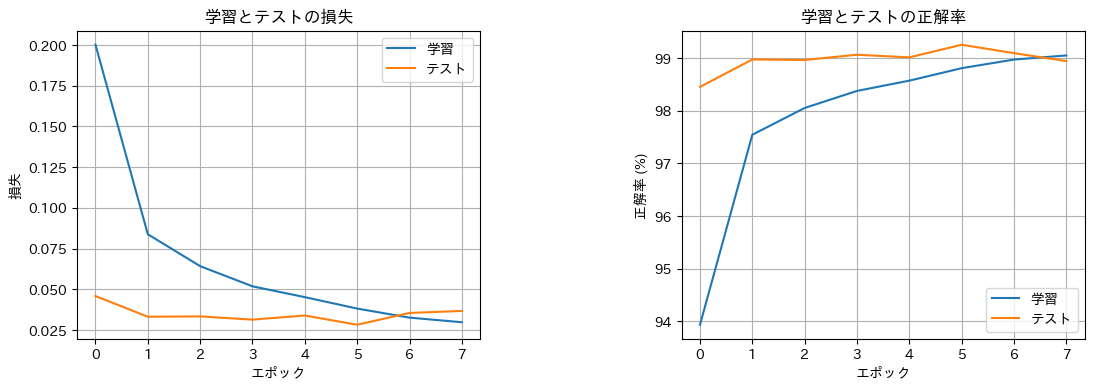

In [10]:
# 学習の経過をグラフで確認する
mn.show_train_graph(history)

1/1 [==============================] - 0s 163ms/step


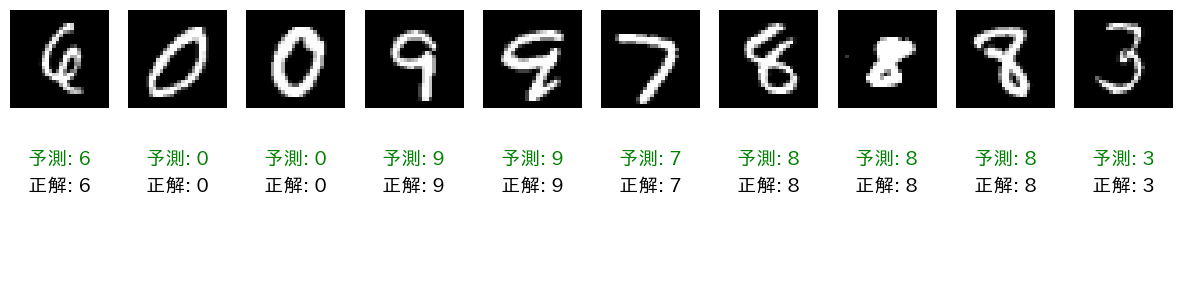

In [11]:
# テストデータから10個ランダムにデータを選択
num_samples = 10  # 表示するテスト結果

mn.predict(num_samples)

In [12]:
# 必要なライブラリをインポートします
from utils import mnist_game  # ユーティリティライブラリからmnist_gameをインポート
import gradio as gr            # デモアプリを作るために必要なgradioライブラリをインポート
import time                    # 時間関連の操作を行うためにtimeライブラリをインポート

# JavaScriptコードを定義します（ブラウザでのポップアップに使用）
js = "(x) => confirm(x)"

# ゲーム用に使用するクラスを定義します
game = mnist_game.HandwritingGame(model)

# Gradioアプリケーションの構築を開始します
with gr.Blocks() as app:
    # ゲームのタイトルと説明を表示します
    gr.Markdown("<div style='text-align: center;'><h1>手書き文字認識ゲーム</h1><h3>1分間に指示された数字を書いて高スコアを狙おう</h3></div>")
    
    # 画面のレイアウトを設定します
    with gr.Row():
        # 画面の左側のレイアウトを設定します
        with gr.Column(scale=5):
            # ユーザー名を入力するためのテキストボックスを作成します
            user_name = gr.Textbox(label="ユーザー名")
            # ゲーム開始とリセットのためのボタンを配置します
            with gr.Row():
                start_button = gr.Button("ゲーム開始")
                reset_button = gr.Button("リセット")
            # ゲームの説明や指示を表示するためのテキストボックスを配置します
            output1 = gr.Textbox(label="説明", interactive=False)
            # ユーザーが数字を描くためのキャンバスを配置します
            image_input = gr.Image(
                source="canvas",
                shape=(200, 200),
                image_mode='L',
                tool='color-sketch',
                invert_colors=True
            ).style(width=800, height=400)
            # 判定とクリアのためのボタンを配置します
            with gr.Row():
                submit_button = gr.Button("判定")
                clear_button = gr.Button("クリア")
            # 判定結果を表示するためのテキストボックスを配置します
            output2 = gr.Textbox(label="結果", interactive=False)
        # 画面の右側のレイアウトを設定します
        with gr.Column(scale=5):
            # モデルの予測結果を表示するためのラベルを配置します
            output3 = gr.Label(label='予測結果', num_top_classes=5, scale=2)
            # スコアボードとランキングを表示するためのテキストボックスを配置します
            with gr.Row():
                score_board = gr.Textbox(label="スコア", value="", lines=15, scale=1)
                total_ranking = gr.Textbox(label="ランキング", value="", lines=15, scale=2)

    # それぞれのボタンに対して、クリックされたタイミングで実行される処理を定義します
    start_button.click(fn=game.start_game, inputs=[output2, user_name, gr.State(False)], outputs=[output1, total_ranking])
    reset_button.click(fn=game.start_game, inputs=[output2, user_name, gr.State(True)], outputs=[output1, total_ranking])
    clear_button.click(fn=lambda x: None, inputs=image_input, outputs=image_input)
    submit_button.click(
        fn=game.recognize_drawing,
        inputs=[output1, output2, image_input],
        outputs=[output1, output2, output3, image_input, score_board]
    )
    # 「説明」のテキストボックスと「結果」のテキストボックスに文字が入力された場合に、実行される処理を定義します
    output1.change(
        fn=None, inputs=output1, outputs=None, _js=js
    )
    output2.change(
        fn=game.start_game, inputs=output2, outputs=[output1, total_ranking], _js=js if time.time() > game.end_time else None
    )

# Gradioアプリケーションを起動します
app.queue().launch(share=True, server_port=7860)

/var/tmp/ipykernel_626523/2127719426.py:30: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  image_input = gr.Image(


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://4be243e907a1768236.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 24ms/step


In [20]:
import numpy as np
np.max(mn.y_train)

9

In [19]:
mn.y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)